In [1]:
# Core imports
import heyoka as hk
import pykep as pk
import numpy as np
from numpy import linalg as la
import pandas as pd
import math
from numpy.lib.function_base import append
from scipy.integrate import odeint
# Sys imports
import time
# Plot imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from UROP_aux_func import rv2elorb, dromo2rv

In [2]:
"""
Constant parameters 
"""

GMe = 398601   #[km^3/sec^2]
Re  = 6371.22  #[km]
J2 = 0.00108265         # [-] second zonal harmonic
GMl = 4902.66 #[km^3/sec^2] for the Moon
rl = 384400   #[km] radius of the lunar orbit
omega_l = 2.665315780887e-6 #[1/s] lunar orbital angular velocity

In [3]:
# create heyoka variables
tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4 = hk.make_vars("tau", "zeta1", "zeta2", "zeta3",
                                                                "eta1", "eta2", "eta3", "eta4")

In [4]:
# Step 1: Define Initial Conditions (dimensional)
r0 = np.array([337.7834, -3109.3490, -6101.4423]) #km   (class 'numpy.ndarray')
v0 = np.array([10.00457,   1.086844,    0])       #km/s
[a0, e0_norm, i0, RAAN0, omega0, theta0] = rv2elorb(r0, v0, GMe)

In [5]:
# Step 2: non-dimensionalise 
r0nd = r0 / a0 #[km/km] = [-] since the orbit is highly elliptical normalise with the initial semimajor axis
               # otherwise use r0nd = r0/la.norm(r0)
v0nd = v0 * math.sqrt(a0/GMe)    #[-]
t0   = 0                         #s
t0nd = t0 / math.sqrt((a0**3)/GMe) #[-]
# Non-dimensionalise the parameters
GMend = 1 # GMe * a0d / (a0d * GMe) 
Rend  = Re / a0
rlnd  = rl / a0
omega_lnd = omega_l * math.sqrt((a0**3)/GMe)
GMlnd = GMl / GMe

In [6]:
# Step 3: tranform the non-dimensional ICs (r0nd, v0nd) in DROMO elements 
h0 = np.cross(r0nd, v0nd)                      # 3-components vector
e0 = - r0nd/la.norm(r0nd) - np.cross(h0, v0nd) # 3-components vector
# sigma0 from page 7. and from page 14. (initial conditions)
sigma0 = theta0 
# Initial state (sigma; tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4)
tau_0   = t0nd
zeta1_0 = la.norm(e0)
zeta2_0 = 0
zeta3_0 = 1/la.norm(h0)
eta1_0  = math.sin(i0/2)*math.cos((RAAN0-omega0)/2)
eta2_0  = math.sin(i0/2)*math.sin((RAAN0-omega0)/2)
eta3_0  = math.cos(i0/2)*math.sin((RAAN0+omega0)/2)
eta4_0  = math.cos(i0/2)*math.cos((RAAN0+omega0)/2)
S0 = [tau_0, zeta1_0, zeta2_0, zeta3_0, eta1_0, eta2_0, eta3_0, eta4_0]

In [7]:
# Valore finale di sigma
# Test - based on 100 orbits
T = 2*np.pi * np.sqrt(a0**3/GMe)  # orbital period
#print(f'the orbital period is {T/(24*3600)} days for one orbit')
n_orb = 1000

sigma_fin = 1000*2*np.pi     
print(sigma_fin)
fin_day =  T*n_orb/(24*3600) # days
print(fin_day)
# numero di passi per orbita
m = 500
N = n_orb * m 

# math.floor((sigma_fin - sigma0)/(2*np.pi)) * m
#delta_sigma = 0.005   
#N = math.floor((sigma_fin-sigma0)/delta_sigma - 1)
print(N)
sigma_span = np.linspace(sigma0, sigma_fin, N)  

6283.185307179586
499.00426437843566
500000


In [78]:
# Auxiliary relationships
s = 1 + zeta1 * hk.cos(hk.time) + zeta2 * hk.sin(hk.time)

In [79]:
# convert from Dromo to State (with heyoka variable)
def dromo2rv_hk(Lc, sigma, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4):
    """
    If you want to have r,v non dimensional from dromo, let Lc be 1.
    Dromo elements to cartesian representation of state vector (page 14)
    Outputs: Dimensional components of position and velocity
    """
    s = 1 + zeta1 * hk.cos(sigma) + zeta2 * hk.sin(sigma)
    alpha = (Lc / (zeta3**2 * s))
    omegacLc = (math.sqrt(GMe/Lc**3) * Lc)

    p11 = 1-2*(eta2**2 + eta3**2)
    p12 = 2*eta1*eta2 - 2*eta4*eta3
    p21 = 2*eta1*eta2 + 2*eta4*eta3
    p22 = 1-2*(eta1**2 + eta3**2)
    p31 = 2*eta1*eta3 - 2*eta4*eta2
    p32 = 2*eta3*eta2 + 2*eta4*eta1

    x = alpha * ( p11*hk.cos(sigma) + p12*hk.sin(sigma) )
    y = alpha * ( p21*hk.cos(sigma) + p22*hk.sin(sigma) )
    z = alpha * ( p31*hk.cos(sigma) + p32*hk.sin(sigma) ) 

    V1 = -zeta3*(hk.sin(sigma)+zeta2)
    V2 =  zeta3*(hk.cos(sigma)+zeta1)

    xv = omegacLc * ( p11*V1 + p12*V2 )
    yv = omegacLc * ( p21*V1 + p22*V2 )
    zv = omegacLc * ( p31*V1 + p32*V2 ) 
    return x, y, z, xv, yv, zv 

In [80]:
x,  y,  z, xv, yv, zv = dromo2rv_hk(a0, hk.time, tau, zeta1, zeta2, zeta3, eta1, eta2, eta3, eta4)
x,  y,  z  = x/a0, y/a0, z/a0
xv, yv, zv = xv*math.sqrt(a0/GMe), yv*math.sqrt(a0/GMe), zv*math.sqrt(a0/GMe)


In [81]:
# Create vectors (Non dimensional) 
r = np.array([x,  y,  z])  # r.shape  = (3, 1)
v = np.array([xv, yv, zv]) 
r_norm = (r[0]**2 + r[1]**2 + r[2]**2)**(1/2)  


In [82]:
# Define the unit vectors of the (local) orbital frame
io = r / r_norm
hx, hy, hz = np.cross(r, v, axis=0)
h_norm = (hx**2 + hy**2 + hz**2)**(1/2)   
ko = np.cross(r, v, axis=0) / h_norm
jo = np.cross(ko, io, axis=0)

In [83]:
# J2
#Earth's J2 terms
fJ2X = ( (3/2)*J2*Rend**2/r_norm**4 ) * (x/r_norm)*(5*(z**2/r_norm**2) -1)
fJ2Y = ( (3/2)*J2*Rend**2/r_norm**4 ) * (y/r_norm)*(5*(z**2/r_norm**2) -1)
fJ2Z = ( (3/2)*J2*Rend**2/r_norm**4 ) * (z/r_norm)*(5*(z**2/r_norm**2) -3)

# Third body (moon)
r3 = np.array([ rlnd * hk.sin(omega_lnd*tau),
                rlnd * (- (math.sqrt(3)*hk.cos(omega_lnd*tau))/2) ,
                rlnd * (- hk.cos(omega_lnd*tau)/2)])
r3_norm  = (r3[0]**2 + r3[1]**2 + r3[2]**2)**(1/2)
r3r      = r3 - np.array([x, y, z])
r3r_norm = (r3r[0]**2 + r3r[1]**2 + r3r[2]**2)**(1/2)

fLX = GMlnd * ( (r3[0] - x)/(r3r_norm**3) - r3[0]/(r3_norm**3) )
fLY = GMlnd * ( (r3[1] - y)/(r3r_norm**3) - r3[1]/(r3_norm**3) )
fLZ = GMlnd * ( (r3[2] - z)/(r3r_norm**3) - r3[2]/(r3_norm**3) )

# Superimpose the accelerations
apx = fJ2X + fLX 
apy = fJ2Y + fLY 
apz = fJ2Z + fLZ
acc = np.array([apx, apy, apz])

# Project into the orbital frame (from inertial frame)
api = np.dot(io, acc) # = apx*xx + apy*xy + apz*xz
apj = np.dot(jo, acc) # = apx*yx + apy*yy + apz*yz
apk = np.dot(ko, acc) # = apx*zx + apy*zy + apz*zz

# Perturbing accelerations
a_px = api/(zeta3**4 * s**3)
a_py = apj/(zeta3**4 * s**3)
a_pz = apk/(zeta3**4 * s**3)

In [84]:
#EOMs

# in heyoka is sigma equivalent to hk.time ?
dtaudsigma    = 1/((zeta3**3) * (s**2)) 
dzeta1dsigma  = s * hk.sin(hk.time)   * a_px   + (zeta1 + (1+s)*hk.cos(hk.time)) * a_py 
dzeta2dsigma  = - s * hk.cos(hk.time) * a_px   + (zeta2 + (1+s)*hk.sin(hk.time)) * a_py
dzeta3dsigma  = - zeta3 * a_py
deta1dsigma   = 1/2 * a_pz * (eta4 * hk.cos(hk.time) - eta3 * hk.sin(hk.time))
deta2dsigma   = 1/2 * a_pz * (eta3 * hk.cos(hk.time) + eta4 * hk.sin(hk.time))
deta3dsigma   = 1/2 * a_pz * (-eta2* hk.cos(hk.time) + eta1 * hk.sin(hk.time))
deta4dsigma   = 1/2 * a_pz * (-eta1* hk.cos(hk.time) - eta2 * hk.sin(hk.time))

In [85]:
sigma_event = []
dromo_state_event = []
sol_event = []

# Callback for the terminal event.
def t_cb(ta, mr, d_sgn):
    # Append the event info
    sigma_event.append(ta.time)
    dromo_state_event.append(ta.state)
    sol_event.append(ta)
    # Do stop the integration.
    return False # False; True

t_ev = hk.t_event(
        # The event equation.
        ((tau * math.sqrt((a0**3)/GMe))/(24*3600)) - fin_day,
        # The callback.
        callback = t_cb)

In [86]:
print('Compiling the Taylor integrator ... (this is done only once)')
start_time = time.time()

ta = hk.taylor_adaptive(sys = [(tau,dtaudsigma),
                               (zeta1,dzeta1dsigma),
                               (zeta2,dzeta2dsigma),
                               (zeta3,dzeta3dsigma),
                               (eta1,deta1dsigma),
                               (eta2,deta2dsigma),
                               (eta3,deta3dsigma),
                               (eta4,deta4dsigma)],
                                state = S0,
                                time = sigma0,
                                tol = 1e-14,
                                compact_mode = True,
                                # The list of terminal events.
                                t_events = [t_ev])

#end_time = time.time()
#print('Done, in');
#print("--- %s seconds ---" % (end_time - start_time))
print("\nHeyoka Taylor integrator:\n", ta)

Compiling the Taylor integrator ... (this is done only once)

Heyoka Taylor integrator:
 Taylor order            : 18
Dimension               : 8
Time                    : 1.2439116403584194e-08
State                   : [0.0000000000000000, 0.74199839476503138, 0.0000000000000000, 1.4916430904506719, -0.34824561477942251, -0.38812607898939389, 0.56984675192683132, -0.63510457242383422]
N of terminal events    : 1



In [87]:
# Here we redefine the initial conditions since we may want to change them without recompiling the integrator
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] =  S0

In [88]:
#start_time = time.time()
out = ta.propagate_grid(sigma_span)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))

#print(out)
sol = out[4] 
size1, size2 = np.shape(sol)
#print(sol[-1])
print(f'the shape of the solution (cartesian form) is {size1, size2}') 

Done, in
--- 3.471052646636963 seconds ---
the shape of the solution (cartesian form) is (496206, 8)


In [89]:
df_dromo = pd.DataFrame(sol, columns=["tau", "z1", "z2", "z3", "h1", "h2", "h3", "h4"])
#print(df_dromo.tail())
#type(sol_event[0])   # heyoka.core._taylor_adaptive_dbl

print("sigma associated with event: ", sigma_event[0], "rad")
print("tau associated with event:   ", dromo_state_event[0][0], dromo_state_event[0][0]*math.sqrt((a0**3)/GMe)/(24*3600))
print("while last tau of output is  ", sol[-1][0])
#dromo2rv(a0, sigma_event[0], *dromo_state_event[0])

rv_event = dromo2rv(a0, sigma_event[0], *dromo_state_event[0])

print(rv_event)
print("norm r: ", (rv_event[0]**2+rv_event[1]**2+rv_event[2]**2)**0.5)
print("norm v: ", (rv_event[3]**2+rv_event[4]**2+rv_event[5]**2)**0.5)


r_a = 46275.720424981366
v_a = 1.5174493221021272

print("error r: ", np.abs(((rv_event[0]**2+rv_event[1]**2+rv_event[2]**2)**0.5)-r_a)*1000 )
print("error v: ", np.abs(((rv_event[3]**2+rv_event[4]**2+rv_event[5]**2)**0.5)-v_a)*1000 )

sigma associated with event:  6235.560136198936 rad
tau associated with event:    6283.185307179586 499.00426437843566
while last tau of output is   6282.953877105224
(18109.735389092944, 11783.298869861112, 40922.28797039093, -0.6306335493562197, 1.3538565175365516, -0.26837716277355395)
norm r:  46275.720424981366
norm v:  1.5174493221021272
error r:  0.0
error v:  0.0


In [362]:
state = np.empty((size1, 6))
r_norm = np.empty((size1, 1))
v_norm = np.empty((size1, 1))

# confronta tempo richiesto da dromo per heyoka, con tempo di una sola conversione da dromo a rv
for row in range(size1):
    state[row, :] = dromo2rv(a0, sigma_span[row], *sol[row, :])
    r_norm[row, 0] = math.sqrt(state[row, 0]**2 + state[row, 1]**2 + state[row, 2]**2 )
    v_norm[row, 0] = math.sqrt(state[row, 3]**2 + state[row, 4]**2 + state[row, 5]**2 )

In [363]:
#print("final state", state[-1, :])

tau_days = np.empty((size1, 1))
for t, i in zip(df_dromo["tau"], range(size1)):
    tau_days[i, 0] = ( t*math.sqrt((a0**3)/GMe) )/(24*3600)
    
print("last day: ", tau_days[-1, :]) 
print(np.shape(tau_days)) #98 431 poi aiiungi l'event 

last day:  [50.27682199]
(99000, 1)


In [356]:
print("sigma associated with event: ", sigma_event[0], "rad")
print("tau associated with event:   ", dromo_state_event[0][0]*math.sqrt((a0**3)/GMe)/(24*3600))
dromo2rv(a0, sigma_event[0], *dromo_state_event[0])



sigma associated with event:  624.7315971016088 rad
tau associated with event:    49.90042643784357


(14739.174102904324,
 15757.94708230248,
 31551.285565525814,
 -1.0362193213928914,
 1.02808010845871,
 1.9496356150464975)

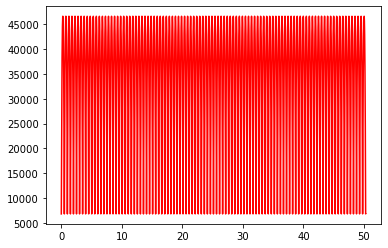

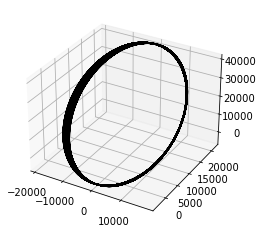

In [220]:
plt.plot(tau_days[:, 0], r_norm[:, 0], 'r')
plt.show()

df_pos = pd.DataFrame(state, columns=["x", "y", "z", "xv", "yv", "zv"])

ax = plt.axes(projection='3d')
ax.plot3D(df_pos["x"], df_pos["y"], df_pos["z"], color = 'k', label = 'orbit')
plt.show()

In [254]:
# Save state
np.savetxt('/Users/utente73/Documents/Uni Project/pos_molnyaD_14.txt', df_pos)

In [255]:
# Save r_norm
np.savetxt('/Users/utente73/Documents/Uni Project/pos_molnyaD_14_r.txt', r_norm)

In [256]:
# Save r_norm
np.savetxt('/Users/utente73/Documents/Uni Project/pos_molnyaD_14_v.txt', v_norm)

In [257]:
# Save time
np.savetxt('/Users/utente73/Documents/Uni Project/pos_molnyaD_14_t.txt', tau_days)

In [259]:
state[-1]

 3.38525260e+02, -3.13632865e+03, -6.09790834e+03,  1.00491102e+01,
       -1.09495668e-01,  3.48655281e-01]

array([ 3.38525260e+02, -3.13632865e+03, -6.09790834e+03,  1.00491102e+01,
       -1.09495668e-01,  3.48655281e-01])